## Topic Modeling: Latent Dirichlet Allocation with sklearn

### Imports

In [1]:
%matplotlib inline
import warnings
from collections import OrderedDict
from pathlib import Path

import numpy as np
import pandas as pd

# Visualization
from ipywidgets import interact, FloatSlider
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

import pyLDAvis
from pyLDAvis.sklearn import prepare

from wordcloud import WordCloud
from termcolor import colored

# spacy for language processing
import spacy

# sklearn for feature extraction & modeling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD, NMF
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib

In [2]:
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14.0, 8.7)
pyLDAvis.enable_notebook()
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format

In [3]:
# change to your data path if necessary
DATA_DIR = Path('../data')
data_path = DATA_DIR / 'bbc'

In [4]:
results_path = Path('results')
model_path = Path('results', 'bbc')
if not model_path.exists():
    model_path.mkdir(exist_ok=True, parents=True)

## Load BBC data

Using the BBC data as before, we use [sklearn.decomposition.LatentDirichletAllocation](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html) to train an LDA model with five topics.

In [6]:
files = sorted(list(data_path.glob('**/*.txt')))
doc_list = []
for i, file in enumerate(files):
    with open(str(file), encoding='latin1') as f:
        topic = file.parts[-2]
        lines = f.readlines()
        heading = lines[0].strip()
        body = ' '.join([l.strip() for l in lines[1:]])
        doc_list.append([topic.capitalize(), heading, body])

### Convert to DataFrame

In [7]:
docs = pd.DataFrame(doc_list, columns=['topic', 'heading', 'article'])
docs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   topic    2225 non-null   object
 1   heading  2225 non-null   object
 2   article  2225 non-null   object
dtypes: object(3)
memory usage: 52.3+ KB


## Create Train & Test Sets

In [8]:
train_docs, test_docs = train_test_split(docs, 
                                         stratify=docs.topic, 
                                         test_size=50, 
                                         random_state=42)

In [9]:
train_docs.shape, test_docs.shape

((2175, 3), (50, 3))

In [10]:
pd.Series(test_docs.topic).value_counts()

Sport            12
Business         11
Tech              9
Entertainment     9
Politics          9
Name: topic, dtype: int64

### Vectorize train & test sets

In [11]:
vectorizer = TfidfVectorizer(max_df=.2, 
                             min_df=.01, 
                             stop_words='english')

train_dtm = vectorizer.fit_transform(train_docs.article)
words = vectorizer.get_feature_names()
train_dtm

<2175x2907 sparse matrix of type '<class 'numpy.float64'>'
	with 205235 stored elements in Compressed Sparse Row format>

In [12]:
test_dtm = vectorizer.transform(test_docs.article)
test_dtm

<50x2907 sparse matrix of type '<class 'numpy.float64'>'
	with 4649 stored elements in Compressed Sparse Row format>

### LDA with sklearn

In [13]:
n_components = 5
topic_labels = ['Topic {}'.format(i) for i in range(1, n_components+1)]

In [14]:
lda_base = LatentDirichletAllocation(n_components=n_components,
                                     n_jobs=-1,
                                     learning_method='batch',
                                     max_iter=10)
lda_base.fit(train_dtm)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=5, n_jobs=-1, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

#### Persist model

The model tracks the in-sample perplexity during training and stops iterating once this measure stops improving. We can persist and load the result as usual with sklearn objects:

In [15]:
joblib.dump(lda_base, model_path / 'lda_10_iter.pkl')

['results/bbc/lda_10_iter.pkl']

In [16]:
lda_base = joblib.load(model_path / 'lda_10_iter.pkl') 
lda_base

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=5, n_jobs=-1, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

### Explore topics & word distributions

In [17]:
# pseudo counts
topics_count = lda_base.components_
print(topics_count.shape)
topics_count[:5]

(5, 2907)


array([[ 4.097539  ,  7.18747767,  1.23773792, ...,  1.10587794,
         0.20006473,  5.39820507],
       [ 0.2000066 ,  4.38602071,  1.68808308, ...,  0.86516325,
        11.57881138,  0.20020019],
       [ 0.20004068,  3.09599019,  3.06853887, ...,  1.33471396,
         0.20029604,  0.38213156],
       [ 0.2002732 ,  1.0358813 ,  0.44764284, ...,  0.20774165,
         0.20005339,  0.20078653],
       [ 0.20000481,  7.27241563,  4.78576002, ...,  0.71363573,
         0.22697916,  0.32854598]])

In [18]:
topics_prob = topics_count / topics_count.sum(axis=1).reshape(-1, 1)
topics = pd.DataFrame(topics_prob.T,
                      index=words,
                      columns=topic_labels)
topics.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
000m,0.00,0.00,0.00,0.00,0.00
10,0.00,0.00,0.00,0.00,0.00
100,0.00,0.00,0.00,0.00,0.00
100m,0.00,0.00,0.00,0.00,0.00
11,0.00,0.00,0.00,0.00,0.00


In [19]:
# all words have positive probability for all topics
topics[topics.gt(0).all(1)].shape[0] == topics.shape[0]

True

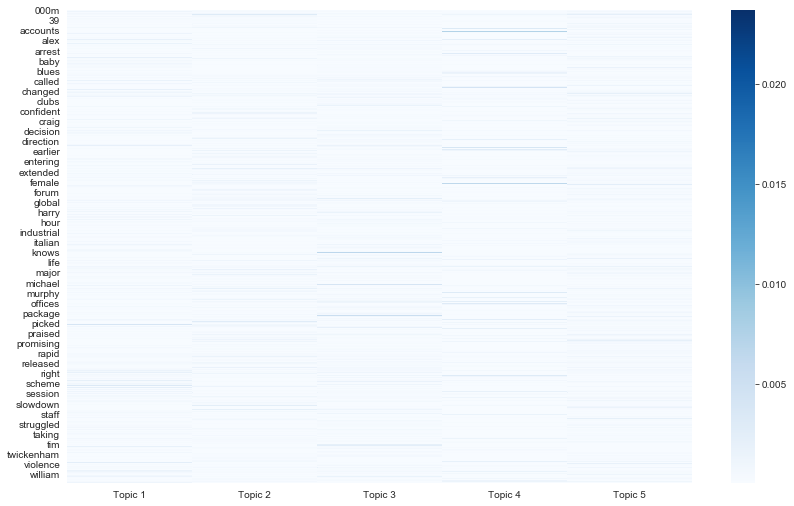

In [20]:
sns.heatmap(topics, cmap='Blues');

In [21]:
top_words = {}
for topic, words_ in topics.items():
    top_words[topic] = words_.nlargest(10).index.tolist()
pd.DataFrame(top_words)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
0,game,mobile,labour,film,company
1,england,growth,election,best,firm
2,win,economy,party,awards,music
3,play,economic,blair,award,shares
4,club,technology,brown,actor,sales
5,team,oil,minister,festival,software
6,match,market,public,films,users
7,cup,games,prime,actress,market
8,players,prices,howard,star,firms
9,season,digital,tax,oscar,companies


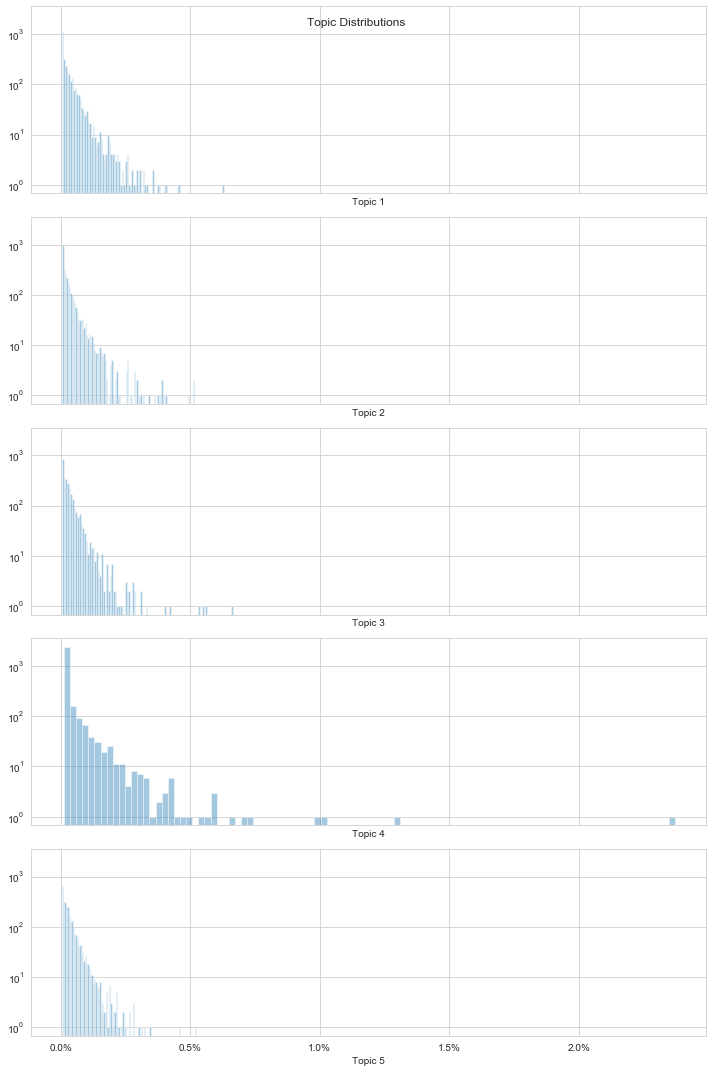

In [22]:
fig, axes = plt.subplots(nrows=5, sharey=True, sharex=True, figsize=(10, 15))
for i, (topic, prob) in enumerate(topics.items()):
    sns.distplot(prob, ax=axes[i], bins=100, kde=False, norm_hist=False)
    axes[i].set_yscale('log')
    axes[i].xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.1%}'.format(x)))
fig.suptitle('Topic Distributions')
fig.tight_layout()

### Evaluate Fit on Train Set

In [23]:
train_preds = lda_base.transform(train_dtm)
train_preds.shape

(2175, 5)

In [24]:
train_eval = pd.DataFrame(train_preds, columns=topic_labels, index=train_docs.topic)
train_eval.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
topic,,,,,
Entertainment,0.03,0.03,0.03,0.41,0.50
Tech,0.02,0.02,0.02,0.02,0.91
Entertainment,0.48,0.03,0.03,0.43,0.03
Business,0.02,0.02,0.02,0.02,0.91
Sport,0.90,0.02,0.03,0.03,0.03


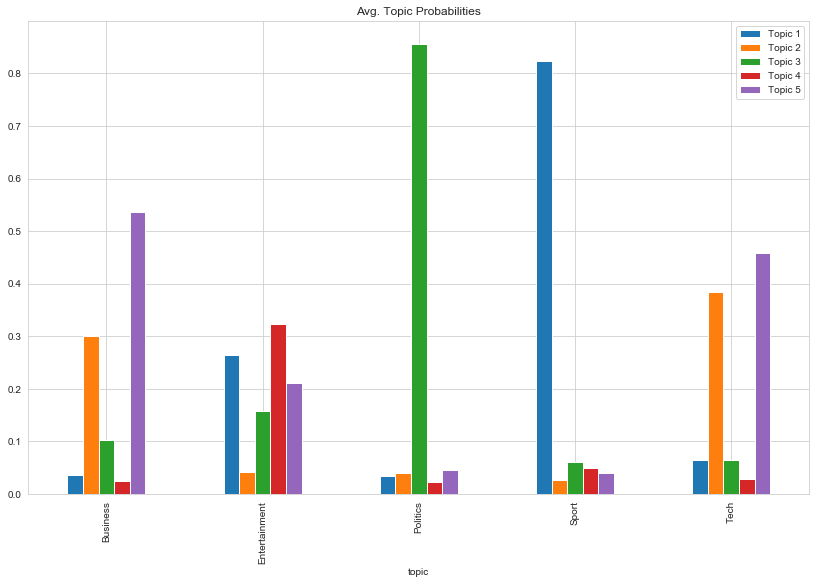

In [25]:
train_eval.groupby(level='topic').mean().plot.bar(title='Avg. Topic Probabilities');

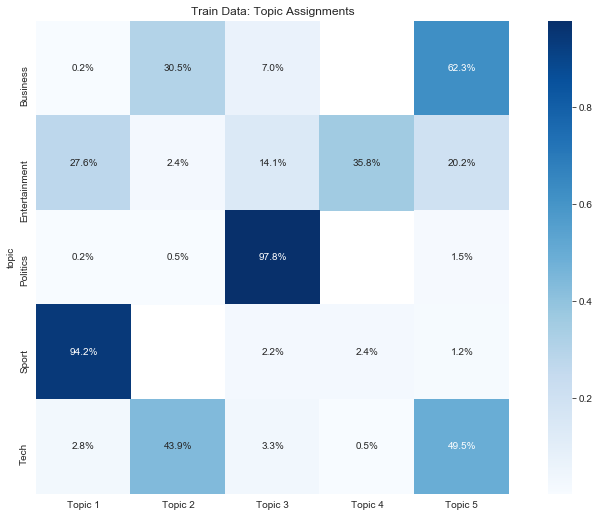

In [26]:
df = train_eval.groupby(level='topic').idxmax(
    axis=1).reset_index(-1, drop=True)
sns.heatmap(df.groupby(level='topic').value_counts(normalize=True)
            .unstack(-1), annot=True, fmt='.1%', cmap='Blues', square=True)
plt.title('Train Data: Topic Assignments');

### Evaluate Fit on Test Set 

In [27]:
test_preds = lda_base.transform(test_dtm)
test_eval = pd.DataFrame(test_preds, columns=topic_labels, index=test_docs.topic)
test_eval.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
topic,,,,,
Entertainment,0.21,0.31,0.03,0.42,0.03
Tech,0.03,0.18,0.02,0.02,0.74
Tech,0.03,0.37,0.02,0.02,0.56
Business,0.02,0.02,0.02,0.02,0.91
Sport,0.88,0.03,0.03,0.03,0.03


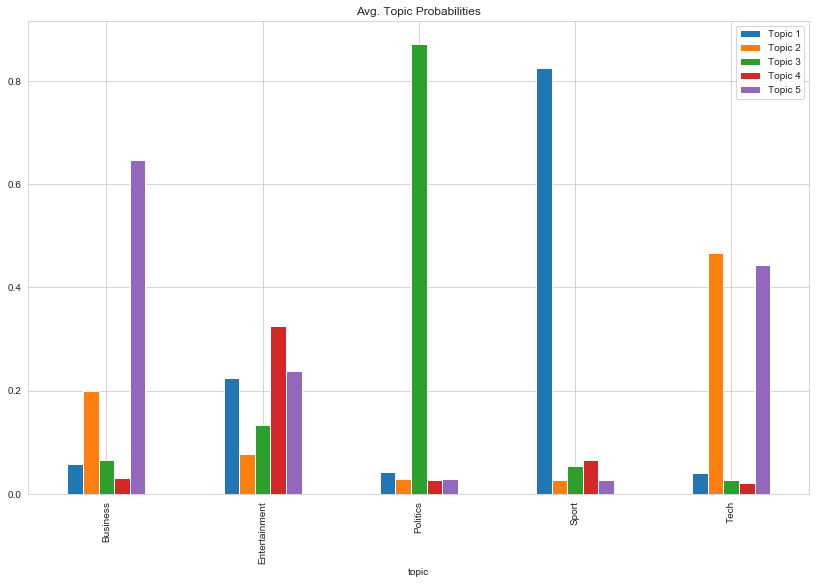

In [28]:
test_eval.groupby(level='topic').mean().plot.bar(title='Avg. Topic Probabilities');

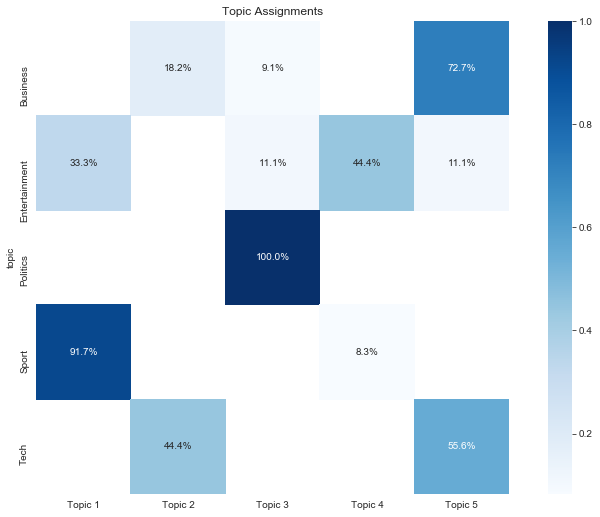

In [29]:
df = test_eval.groupby(level='topic').idxmax(
    axis=1).reset_index(-1, drop=True)
sns.heatmap(df.groupby(level='topic').value_counts(normalize=True)
            .unstack(-1), annot=True, fmt='.1%', cmap='Blues', square=True)
plt.title('Topic Assignments');

### Retrain until perplexity no longer decreases

In [30]:
lda_opt = LatentDirichletAllocation(n_components=5, 
                                    n_jobs=-1, 
                                    max_iter=500,
                                    learning_method='batch', 
                                    evaluate_every=5,
                                    verbose=1, 
                                    random_state=42)
lda_opt.fit(train_dtm)

iteration: 1 of max_iter: 500
iteration: 2 of max_iter: 500
iteration: 3 of max_iter: 500
iteration: 4 of max_iter: 500
iteration: 5 of max_iter: 500, perplexity: 5283.4095
iteration: 6 of max_iter: 500
iteration: 7 of max_iter: 500
iteration: 8 of max_iter: 500
iteration: 9 of max_iter: 500
iteration: 10 of max_iter: 500, perplexity: 5001.2091
iteration: 11 of max_iter: 500
iteration: 12 of max_iter: 500
iteration: 13 of max_iter: 500
iteration: 14 of max_iter: 500
iteration: 15 of max_iter: 500, perplexity: 4933.1228
iteration: 16 of max_iter: 500
iteration: 17 of max_iter: 500
iteration: 18 of max_iter: 500
iteration: 19 of max_iter: 500
iteration: 20 of max_iter: 500, perplexity: 4912.9456
iteration: 21 of max_iter: 500
iteration: 22 of max_iter: 500
iteration: 23 of max_iter: 500
iteration: 24 of max_iter: 500
iteration: 25 of max_iter: 500, perplexity: 4901.5196
iteration: 26 of max_iter: 500
iteration: 27 of max_iter: 500
iteration: 28 of max_iter: 500
iteration: 29 of max_iter:

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=5, learning_decay=0.7, learning_method='batch',
             learning_offset=10.0, max_doc_update_iter=100, max_iter=500,
             mean_change_tol=0.001, n_components=5, n_jobs=-1,
             n_topics=None, perp_tol=0.1, random_state=42,
             topic_word_prior=None, total_samples=1000000.0, verbose=1)

In [31]:
joblib.dump(lda_opt, model_path / 'lda_opt.pkl')

['results/bbc/lda_opt.pkl']

In [32]:
lda_opt = joblib.load(model_path / 'lda_opt.pkl')

In [33]:
train_opt_eval = pd.DataFrame(data=lda_opt.transform(train_dtm),
                              columns=topic_labels,
                              index=train_docs.topic)

In [34]:
test_opt_eval = pd.DataFrame(data=lda_opt.transform(test_dtm),
                             columns=topic_labels, 
                             index=test_docs.topic)

### Compare Train & Test Topic Assignments 

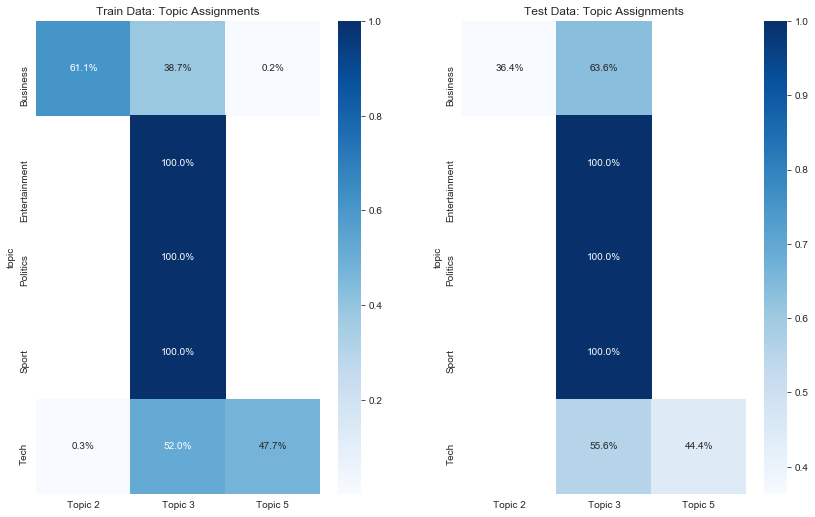

In [35]:
fig, axes = plt.subplots(ncols=2)
source = ['Train', 'Test']
for i, df in enumerate([train_opt_eval, test_opt_eval]):
    df = df.groupby(level='topic').idxmax(
    axis=1).reset_index(-1, drop=True)
    sns.heatmap(df.groupby(level='topic').value_counts(normalize=True)
            .unstack(-1), annot=True, fmt='.1%', cmap='Blues', square=True, ax=axes[i])
    axes[i].set_title('{} Data: Topic Assignments'.format(source[i]));

### Explore misclassified articles 

In [36]:
test_assignments = test_opt_eval.groupby(level='topic').idxmax(axis=1)
test_assignments = test_assignments.reset_index(-1, drop=True).to_frame('predicted').reset_index()
test_assignments['heading'] = test_docs.heading.values
test_assignments['article'] = test_docs.article.values
test_assignments.head()

,topic,predicted,heading,article
0,Business,Topic 3,Animation charms Japan box office,Oscar-winning director Hayao Miyazaki's lates...
1,Business,Topic 3,Satellite mapping aids Darfur relief,"Aid workers trying to house, feed and clothe ..."
2,Business,Topic 3,'Evil twin' fear for wireless net,People using wireless high-speed net (wi-fi) ...
3,Business,Topic 2,US bank in $515m SEC settlement,Five Bank of America subsidiaries have agreed...
4,Business,Topic 3,Ronaldo considering new contract,Manchester United winger Cristiano Ronaldo sa...


In [37]:
misclassified = test_assignments[(test_assignments.topic == 'business') & (
    test_assignments.predicted == 'Topic 3')]
misclassified.heading

Series([], Name: heading, dtype: object)

In [38]:
misclassified.article.tolist()

[]

### PyLDAVis

LDAvis helps you interpret LDA results by answer 3 questions:

1. What is the meaning of each topic?
2. How prevalent is each topic?
3. How do topics relate to each other?

Topic visualization facilitates the evaluation of topic quality using human judgment. pyLDAvis is a python port of LDAvis, developed in R and D3.js. We will introduce the key concepts; each LDA implementation notebook contains examples.

pyLDAvis displays the global relationships among topics while also facilitating their semantic evaluation by inspecting the terms most closely associated with each individual topic and, inversely, the topics associated with each term. It also addresses the challenge that terms that are frequent in a corpus tend to dominate the multinomial distribution over words that define a topic. LDAVis introduces the relevance r of term w to topic t to produce a flexible ranking of key terms using a weight parameter 0<=ƛ<=1. 

With $\phi_{wt}$  as the model’s probability estimate of observing the term w for topic t, and   as the marginal probability of w in the corpus:
$$r(w, k | \lambda) = \lambda \log(\phi_{kw}) + (1 − \lambda) \log \frac{\phi_{kw}}{p_w}$$

The first term measures the degree of association of term t with topic w, and the second term measures the lift or saliency, i.e., how much more likely the term is for the topic than in the corpus. 

The tool allows the user to interactively change ƛ to adjust the relevance, which updates the ranking of terms. User studies have found that ƛ=0.6 produces the most plausible results. 

#### Refit using all data

In [39]:
vectorizer = CountVectorizer(max_df=.5, 
                             min_df=5,
                             stop_words='english',
                             max_features=2000)
dtm = vectorizer.fit_transform(docs.article)

In [40]:
lda_all = LatentDirichletAllocation(n_components=5,
                                    max_iter=500,
                                    learning_method='batch',
                                    evaluate_every=10,
                                    random_state=42,
                                    verbose=1)
lda_all.fit(dtm)

iteration: 1 of max_iter: 500
iteration: 2 of max_iter: 500
iteration: 3 of max_iter: 500
iteration: 4 of max_iter: 500
iteration: 5 of max_iter: 500
iteration: 6 of max_iter: 500
iteration: 7 of max_iter: 500
iteration: 8 of max_iter: 500
iteration: 9 of max_iter: 500
iteration: 10 of max_iter: 500, perplexity: 1019.9467
iteration: 11 of max_iter: 500
iteration: 12 of max_iter: 500
iteration: 13 of max_iter: 500
iteration: 14 of max_iter: 500
iteration: 15 of max_iter: 500
iteration: 16 of max_iter: 500
iteration: 17 of max_iter: 500
iteration: 18 of max_iter: 500
iteration: 19 of max_iter: 500
iteration: 20 of max_iter: 500, perplexity: 1006.8139
iteration: 21 of max_iter: 500
iteration: 22 of max_iter: 500
iteration: 23 of max_iter: 500
iteration: 24 of max_iter: 500
iteration: 25 of max_iter: 500
iteration: 26 of max_iter: 500
iteration: 27 of max_iter: 500
iteration: 28 of max_iter: 500
iteration: 29 of max_iter: 500
iteration: 30 of max_iter: 500, perplexity: 1003.1615
iteration:

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=10, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=500, mean_change_tol=0.001,
             n_components=5, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=42, topic_word_prior=None,
             total_samples=1000000.0, verbose=1)

In [41]:
joblib.dump(lda_all, model_path /'lda_all.pkl')

['results/bbc/lda_all.pkl']

In [42]:
lda_all = joblib.load(model_path / 'lda_all.pkl') 

#### Lambda

- **$\lambda$ = 0**: how probable is a word to appear in a topic - words are ranked on lift P(word | topic) / P(word)
- **$\lambda$ = 1**: how exclusive is a word to a topic -  words are purely ranked on P(word | topic)

The ranking formula is $\lambda * P(\text{word} \vert \text{topic}) + (1 - \lambda) * \text{lift}$

User studies suggest $\lambda = 0.6$ works for most people.

In [43]:
prepare(lda_all, dtm, vectorizer)

PreparedData(topic_coordinates=          x     y  topics  cluster  Freq
topic                                   
2      0.07  0.08       1        1 25.50
3      0.10 -0.10       2        1 21.84
0      0.14  0.01       3        1 20.95
4     -0.14  0.14       4        1 18.69
1     -0.17 -0.13       5        1 13.01, topic_info=         Term     Freq    Total Category  logprob  loglift
1200       mr 2,987.00 2,987.00  Default    30.00    30.00
724      film   838.00   838.00  Default    29.00    29.00
230      best   960.00   960.00  Default    28.00    28.00
1022   labour   770.00   770.00  Default    27.00    27.00
780      game   855.00   855.00  Default    26.00    26.00
...       ...      ...      ...      ...      ...      ...
1081   london   145.60   454.66   Topic5    -5.54     0.90
1816     time   158.75 1,303.51   Topic5    -5.46    -0.07
1607   series   135.44   252.07   Topic5    -5.61     1.42
1977    world   147.43 1,173.23   Topic5    -5.53    -0.03
1165  million   135.60   574.10   Topic5    -5.61     0.60

[353 rows x 6 columns], token_table=      Topic  Freq     Term
term                      
0         1  0.27      000
0         2  0.22      000
0         3  0.38      000
0         4  0.01      000
0         5  0.12      000
...     ...   ...      ...
1992      4  0.19    years
1992      5  0.23    years
1997      3  0.99  yugansk
1998      3  1.00    yukos
1999      4  0.99  zealand

[672 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 1, 5, 2])

### Topics as WordClouds

In [44]:
topics_prob = lda_all.components_ / lda_all.components_.sum(axis=1).reshape(-1, 1)
topics = pd.DataFrame(topics_prob.T,
                      index=vectorizer.get_feature_names(),
                      columns=topic_labels)

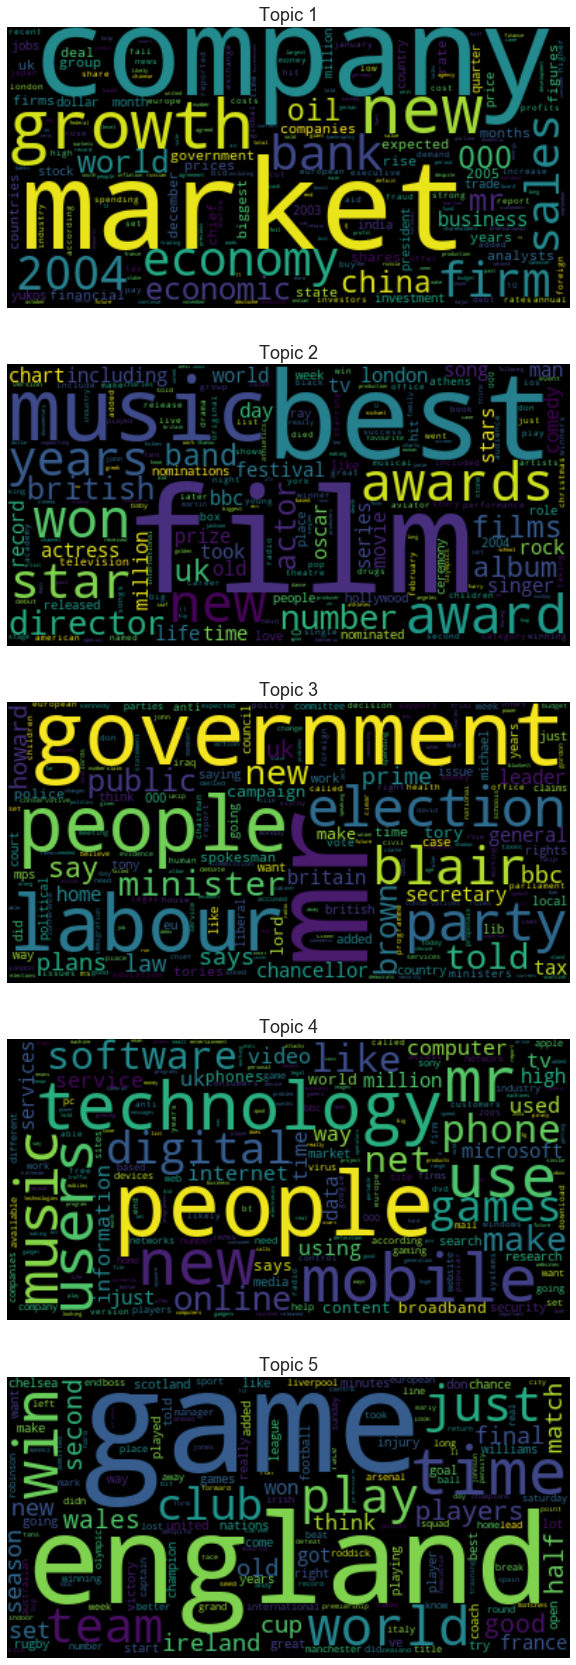

In [45]:
w = WordCloud()
fig, axes = plt.subplots(nrows=5, figsize=(15, 30))
axes = axes.flatten()
for t, (topic, freq) in enumerate(topics.items()):
    w.generate_from_frequencies(freq.to_dict())
    axes[t].imshow(w, interpolation='bilinear')
    axes[t].set_title(topic, fontsize=18)
    axes[t].axis('off')

### Visualize topic-word assocations per document

In [46]:
dtm_ = pd.DataFrame(data=lda_all.transform(dtm),
                    columns=topic_labels,
                    index=docs.topic)

In [47]:
color_dict = OrderedDict()
color_dict['Topic 1'] = {'color': 'white', 'on_color': 'on_blue'}
color_dict['Topic 2'] = {'color': 'white', 'on_color': 'on_green'}
color_dict['Topic 3'] = {'color': 'white', 'on_color': 'on_red'}
color_dict['Topic 4'] = {'color': 'white', 'on_color': 'on_magenta'}
color_dict['Topic 5'] = {'color': 'blue', 'on_color': 'on_yellow'}

In [48]:
dtm_['article'] = docs.article.values
dtm_['heading'] = docs.heading.values
sample = dtm_[dtm_[topic_labels].gt(.1).all(1)]
sample

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,article,heading
topic,,,,,,,
Entertainment,0.14,0.28,0.23,0.23,0.11,Women in the UK film industry earn less than ...,Women in film 'are earning less'


In [49]:
colored_text = []
for word in sample.iloc[0, 5].split():
    try:
        topic = topics.loc[word.strip().lower()].idxmax()
        colored_text.append(colored(word, **color_dict[topic]))
    except:
        colored_text.append(word)

print(' '.join([colored(k, **v) for k, v in color_dict.items()]))
print('\n',sample.iloc[0, 6], '\n')
text = ' '.join(colored_text)
print(text)

Topic 1 Topic 2 Topic 3 Topic 4 Topic 5

 Women in film 'are earning less' 

Women in the UK film industry earn less than their male counterparts despite being better qualified, according to a study released on Wednesday. Only 16% of women earn more than Â£50,000, compared with 30% of men. Women make up a third of the workforce. The research was carried out jointly by the UK Film Council and industry training body Skillset. It also found that women in the industry were less likely than men to be married or have dependant children. The study, which claims to be the most in-depth so far conducted, found 60% of women in the film industry hold degrees, compared with 39% of men. Whilst 17% of men in the industry had no qualifications, this was true for only five per cent of women. In the lower salary bracket, 35% of women earn less than Â£20,000 a year, compared to only 18% of men. The research found very few women worked in the camera, sound, electrical and construction departments, but th